# Random interfaces

The final result of Rob's calculation is that an interface should obey the probability distribution

$$P(\rm curve)\propto \Pi_{n=1}^K \exp\left[\dfrac{\pi^2\gamma}{8 R\phi T}a_n (n^2-1)\right]$$

Tis should provide a recipe to generate 

$$r(\theta) = R+ \sum_{n=1}^K a_n \sin\left(\dfrac{n\pi}{2\phi}(\theta+\phi)\right)$$

Here is a simple implementation.

In [60]:
import numpy as np


def generate_curve(R = 1.0, energy = 1.0, phi = np.pi/2., K = 100,ntheta = 50):
    """
    Generate a random interface.
    
    Parameteres:
        R: radius
        energy: gamma/T
        phi: half-angle
        K: Fourier knots
        ntheta: number of angular evaluations
    """
    
    ns = np.arange(2,K+1, dtype=int)
    variances = 2./( np.pi**2*energy/(8*R*phi)*(ns**2-1))
    stds = np.sqrt(variances)
    # generate all coefficients n>=2
    a2s  = np.array([np.random.normal(0,stds[i]) for i in range(K-1)])
    
    a1 = - np.sum(a2s)
    a = np.concatenate([[a1],a2s]) 
    n = np.concatenate([[1],ns]) 
    #  sample n-2 coefficients
    assert len(a)==K, "Incorrect lengths"
    
    # generate theta range
    theta = np.linspace(-phi,phi,ntheta)
    # calculate sine argument
    prod = np.multiply.outer((theta+phi),np.pi*n/(2*phi))
    r = np.ones(ntheta)*R+(a*np.sin(prod)).sum(axis=1)
    
    #impose boundaries
    r[0]=r[-1] = 0
    # get Cartesian coordinates
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x, y,r,theta

We then generate some paths

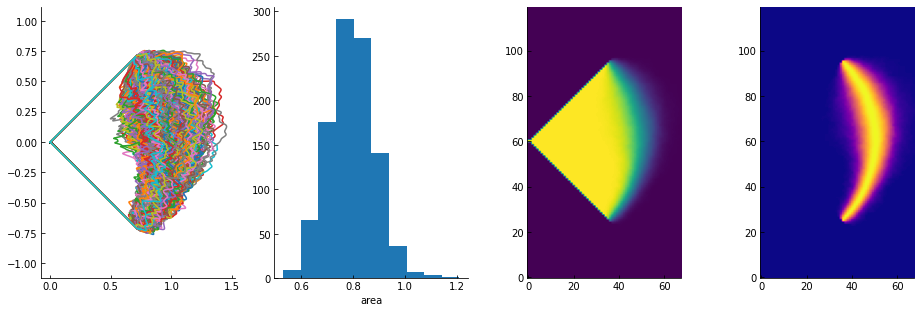

In [79]:
## import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import matplotlib.path as mpltPath

areas = []
rhos = []
fig,ax = plt.subplots(1,4, figsize=(16,5))
dx = dy = 0.02
xlo = 0.0
xhi = 1.35
ylo =  -1.2
yhi = 1.2
gridx,gridy = np.mgrid[xlo:xhi:dx,ylo:yhi:dy]
for k in range(1000):
    x,y,r,theta  = generate_curve(phi= np.pi/4, energy = 100, K=100, ntheta=2000)
    ax[0].plot(x,y)
    shape = Polygon([(xx,yy) for xx,yy in zip(x,y)])
    areas.append(shape.area)
    
    #use faster matplotlib function to check grid
    polygon = np.array([x,y]).T
    path = mpltPath.Path(polygon)
    points = np.array([gridx.ravel(),gridy.ravel()]).T
    contained = path.contains_points(points)
    rhos.append(contained.astype(np.float32).reshape(gridx.shape))
    # second estimate of the area from the grid
    area_from_ratio = contained.sum()/len(contained)*(xhi-xlo)*(yhi-ylo)
#     print(shape.area, area_from_ratio)
    
#     
ax[0].axis('equal');
ax[1].hist(areas);
ax[1].set_xlabel('area')
ax[2].imshow(np.mean(rhos,axis=0).T, origin='lower')
ax[3].imshow(np.var(rhos,axis=0).T, origin='lower', cmap=plt.cm.plasma)

In [80]:
plt.savefig("one_thousands_paths.png")

<Figure size 432x288 with 0 Axes>